In [1]:
import numpy as np
import sunpy
import sunpy.map
from sunpy.coordinates import propagate_with_solar_surface
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
from matplotlib.patches import Polygon
from matplotlib import rc_context
from matplotlib import patheffects as path_effects
import astropy.units as u
from astropy.coordinates import SkyCoord
import astropy.constants as const
from astropy.time import Time
from astropy.visualization import (ImageNormalize, AsinhStretch,
                                   ZScaleInterval)
from map_coalign import MapSequenceCoalign
from glob import glob
from watroo import wow
from skimage import draw, measure
import skimage.measure.profile
from ndcube import NDCube
from ndcube.extra_coords import (TimeTableCoordinate,
                                 QuantityTableCoordinate)
from fancy_colorbar import plot_colorbar, wcs_scalebar
import cmcrameri.cm as cmcm
import cv2

In [2]:
ms_style_dict = {'text.usetex': True, 'font.family': 'serif', 'axes.linewidth': 1.2,
                 'xtick.major.width': 1.2, 'xtick.major.size': 4,
                 'ytick.major.width': 1.2, 'ytick.major.size': 4,
                 'xtick.minor.width': 1.2, 'xtick.minor.size': 2,
                 'ytick.minor.width': 1.2, 'ytick.minor.size': 2,
                 'xtick.direction': 'in', 'ytick.direction': 'in',
                 'text.latex.preamble': r'\usepackage[T1]{fontenc}'
                 r'\usepackage{amsmath}' r'\usepackage{siunitx}'
                 r'\sisetup{detect-all=True}' r'\usepackage{fixltx2e}'}

In [3]:
hri_1020_files = sorted(glob("../../src/EUI/HRI/euv174/20221020/coalign_step_boxcar/*.fits"))
hri_1020_map_seq = MapSequenceCoalign(sunpy.map.Map(hri_1020_files))
hri_1020_map_seq = hri_1020_map_seq.submap(bottom_left=[300,760]*u.pix, top_right=[430,890]*u.pix)
hri_1020_map_seq_data = hri_1020_map_seq.as_array()

In [4]:
hri_1020_map_mean = np.nanmean(hri_1020_map_seq_data, axis=-1)
hri_1020_map_seq_noise_pixel = np.where(hri_1020_map_mean < np.nanpercentile(hri_1020_map_mean, 0.5))
hri_1020_map_noise_level_est = np.nanmean(np.nanstd(hri_1020_map_seq_data[*hri_1020_map_seq_noise_pixel, :],axis=-1))
hri_1020_map_std = np.sqrt(np.nanstd(hri_1020_map_seq_data, axis=-1)**2 - hri_1020_map_noise_level_est**2)/hri_1020_map_mean
hri_1020_map_std = np.nan_to_num(hri_1020_map_std, nan=0.0,)

/tmp/ipykernel_478942/2177313113.py:4: RuntimeWarning: invalid value encountered in sqrt
  hri_1020_map_std = np.sqrt(np.nanstd(hri_1020_map_seq_data, axis=-1)**2 - hri_1020_map_noise_level_est**2)/hri_1020_map_mean


In [5]:
hri_1020_Txshift = (9.41462 - 20.8515)*u.arcsec
hri_1020_Tyshift = (7.05089-8.29747)*u.arcsec
hri_1020_map_wow = hri_1020_map_seq[181].shift_reference_coord(hri_1020_Txshift,hri_1020_Tyshift)
hri_1020_map_wow = sunpy.map.Map(wow(hri_1020_map_wow.data, bilateral=1, denoise_coefficients=[5,3])[0],
                                 hri_1020_map_wow.meta)
hri_1020_map_std = sunpy.map.Map(hri_1020_map_std, hri_1020_map_wow.meta)

In [6]:
spice_NeVIII_vel_map_1020_zoomin = sunpy.map.Map("../../src/coalign_map/20221020/saffron_vel_map_zoomin_east.fits")

In [7]:
hri_1026_files = sorted(glob("../../src/EUI/HRI/euv174/20221026/coalign_step_boxcar/*.fits"))
hri_1026_map_seq = MapSequenceCoalign(sunpy.map.Map(hri_1026_files))
hri_1026_map_seq = hri_1026_map_seq.submap(bottom_left=[1780,480]*u.pix, top_right=[1950,650]*u.pix)
hri_1026_map_seq_data = hri_1026_map_seq.as_array()

In [8]:
hri_1026_map_mean = np.nanmean(hri_1026_map_seq_data, axis=-1)
hri_1026_map_seq_noise_pixel = np.where(hri_1026_map_mean < np.nanpercentile(hri_1026_map_mean, 0.5))
hri_1026_map_noise_level_est = np.nanmean(np.nanstd(hri_1026_map_seq_data[*hri_1026_map_seq_noise_pixel, :],axis=-1))
hri_1026_map_std = np.sqrt(np.nanstd(hri_1026_map_seq_data, axis=-1)**2 - hri_1026_map_noise_level_est**2)/hri_1026_map_mean
hri_1026_map_std = np.nan_to_num(hri_1026_map_std, nan=0.0,)

/tmp/ipykernel_478942/356689771.py:4: RuntimeWarning: invalid value encountered in sqrt
  hri_1026_map_std = np.sqrt(np.nanstd(hri_1026_map_seq_data, axis=-1)**2 - hri_1026_map_noise_level_est**2)/hri_1026_map_mean


In [9]:
hri_1026_Txshift = (-0.0235313 - 6.3736)*u.arcsec
hri_1026_Tyshift = (7.82867 - 0.685765)*u.arcsec
hri_1026_map_wow = hri_1026_map_seq[181].shift_reference_coord(hri_1026_Txshift,hri_1026_Tyshift)
hri_1026_map_wow = sunpy.map.Map(wow(hri_1026_map_wow.data, bilateral=1, denoise_coefficients=[5,3])[0],
                                 hri_1026_map_wow.meta)
hri_1026_map_std = sunpy.map.Map(hri_1026_map_std, hri_1026_map_wow.meta)

In [10]:
def generate_slit_data(select_x, select_y, line_width, image_seq_prep, wcs_index=0, map_wcs=None):
    pixels_idy, pixels_idx = None, None
    nt = image_seq_prep.nt

    for ii in range(len(select_x) - 1):
        pixels_idy_, pixels_idx_ = measure.profile._line_profile_coordinates(
            (select_y[ii], select_x[ii]),
            (select_y[ii + 1], select_x[ii + 1]),
            linewidth=line_width
        )
        if ii == 0:
            pixels_idy, pixels_idx = pixels_idy_, pixels_idx_
        else:
            pixels_idy = np.vstack((pixels_idy, pixels_idy_[1:]))
            pixels_idx = np.vstack((pixels_idx, pixels_idx_[1:]))

    pixels_idy_center = np.nanmean(pixels_idy, axis=1)
    pixels_idx_center = np.nanmean(pixels_idx, axis=1)

    world_coord_center, world_coord_all, world_coord_center_distance = None, None, None

    world_coord_center = map_wcs.pixel_to_world(pixels_idx_center, pixels_idy_center)
    world_coord_all = map_wcs.pixel_to_world(pixels_idx, pixels_idy)

    world_coord_center_distance = []
    for ii, pixels_center_ in enumerate(world_coord_center):
        if ii == 0:
            world_coord_center_distance.append(0 * u.arcsec)
        else:
            world_coord_center_distance.append(
                world_coord_center[ii].separation(world_coord_center[ii - 1]).to(u.arcsec) +
                world_coord_center_distance[ii - 1]
            )
    world_coord_center_distance = u.Quantity(world_coord_center_distance).to_value(u.rad) * image_seq_prep[wcs_index].dsun
    world_coord_center_distance_interp = np.linspace(
        world_coord_center_distance[0], world_coord_center_distance[-1],
        len(world_coord_center_distance)
    )


    pixel_distance = np.cumsum(np.sqrt(np.diff(pixels_idx_center) ** 2 + np.diff(pixels_idy_center) ** 2))
    pixel_distance = np.insert(pixel_distance, 0, 0)
    pixel_distance_interp = np.linspace(pixel_distance[0], pixel_distance[-1], len(pixel_distance))

    intensity = []
    for tt in range(nt):
        for ii in range(len(select_x) - 1):

            line = measure.profile_line(
                image_seq_prep[tt].data, (select_y[ii], select_x[ii]),
                (select_y[ii + 1], select_x[ii + 1]), linewidth=line_width,
                reduce_func=np.nanmean
            )

            if ii == 0:
                intensity_ = line
            else:
                intensity_ = np.concatenate((intensity_, line[1:]))

        intensity_interp = np.interp(world_coord_center_distance_interp, world_coord_center_distance, intensity_)

        intensity.append(intensity_interp)

    slit_intensity = u.Quantity(intensity).T
    # slit_intensity_sharp = skimage.filters.unsharp_mask(slit_intensity, radius=(31,0), amount=1.5, preserve_range=True)
    slit_intensity_sharp = slit_intensity - cv2.GaussianBlur(slit_intensity,(1,29),0,10)
    # slit_intensity_sharp = np.gradient(slit_intensity, axis=-1)
    
    # slit_intensity_sharp = skimage.filters.sato(slit_intensity, sigmas=[1,], black_ridges=False)
    # slit_intensity_sharp = skimage.filters.butterworth(slit_intensity, 0.005, order=2)
    # slit_intensity_sharp = slit_intensity - np.nanmean(slit_intensity, axis=-1)[:,np.newaxis]
    # slit_intensity_sharp = slit_intensity_sharp/np.nanmean(slit_intensity_sharp, axis=-1)[:,np.newaxis]

    spacetime_wcs = (
        TimeTableCoordinate(Time([map_.date for map_ in image_seq_prep]), physical_types="time", names="time") &
        QuantityTableCoordinate(world_coord_center_distance_interp.to(u.Mm), physical_types="length", names="distance")
    ).wcs
    slit_cube = NDCube(slit_intensity_sharp, spacetime_wcs)

    return pixels_idx, pixels_idy, slit_cube

In [11]:
def plot_slit_position(pixels_idx, pixels_idy, ax1, ax2, triangle_length=1, triangle_anchor_index=5, triangle_ratio=0.6,
                       color='#58B2DC', lw=1, alpha=0.8, text=None, text_color=None, text_offset=10, text_fontsize=10):
    boundary_x = np.concatenate((pixels_idx[:, 0], pixels_idx[-1, 1:], pixels_idx[-1::-1, -1], pixels_idx[0, -1::-1]))
    boundary_y = np.concatenate((pixels_idy[:, 0], pixels_idy[-1, 1:], pixels_idy[-1::-1, -1], pixels_idy[0, -1::-1]))

    slit_boundary_collection = []
    boundary_x_line2d_ax1 = mlines.Line2D(boundary_x, boundary_y, color=color, lw=lw, alpha=alpha)
    boundary_x_line2d_ax2 = mlines.Line2D(boundary_x, boundary_y, color=color, lw=lw, alpha=alpha)
    slit_boundary_collection.append(ax1.add_line(boundary_x_line2d_ax1))
    slit_boundary_collection.append(ax2.add_line(boundary_x_line2d_ax2))

    triangle_anchor_point_0 = np.array([pixels_idx[triangle_anchor_index, 0], pixels_idy[triangle_anchor_index, 0]])
    triangle_anchor_point_1 = np.array([pixels_idx[triangle_anchor_index + triangle_length, 0], pixels_idy[triangle_anchor_index + triangle_length, 0]])
    triangle_bottom_vec = triangle_anchor_point_1 - triangle_anchor_point_0
    triangle_bottom_vec_rot_90 = np.array([triangle_bottom_vec[1], -triangle_bottom_vec[0]])*triangle_ratio
    triangle_anchor_point_2 = triangle_anchor_point_0 + triangle_bottom_vec_rot_90

    triangle_points = np.vstack((triangle_anchor_point_0, triangle_anchor_point_1, triangle_anchor_point_2,))
    
    for ax_ in (ax1,ax2):
        triangle_patch = Polygon(triangle_points, closed=True, edgecolor=color, facecolor=color, alpha=alpha)
        ax_.add_patch(triangle_patch)

    if text is not None:
        if text_color is None:
            text_color = color
        slit_center_x = np.nanmean(pixels_idx)
        slit_center_y = np.nanmean(pixels_idy)
        triangle_bottom_vec_rot_90_norm = triangle_bottom_vec_rot_90/np.linalg.norm(triangle_bottom_vec_rot_90)

        for ax_ in (ax1, ax2):
            ax_.text(slit_center_x + text_offset*triangle_bottom_vec_rot_90_norm[0], 
                     slit_center_y + text_offset*triangle_bottom_vec_rot_90_norm[1], text,
                    color=text_color, fontsize=text_fontsize, ha='center', va='center',
                    )


    return slit_boundary_collection

In [12]:
hri_1026_map_wow.wcs.world_to_pixel(SkyCoord(1882*u.arcsec + hri_1026_Txshift, 448*u.arcsec + hri_1026_Tyshift, frame=hri_1026_map_wow.coordinate_frame))

(array(14.36796876), array(90.53756491))

In [13]:
hri_1026_map_wow.wcs.world_to_pixel(SkyCoord(1908*u.arcsec + hri_1026_Txshift, 461*u.arcsec + hri_1026_Tyshift, frame=hri_1026_map_wow.coordinate_frame))

(array(68.77557016), array(113.57321188))

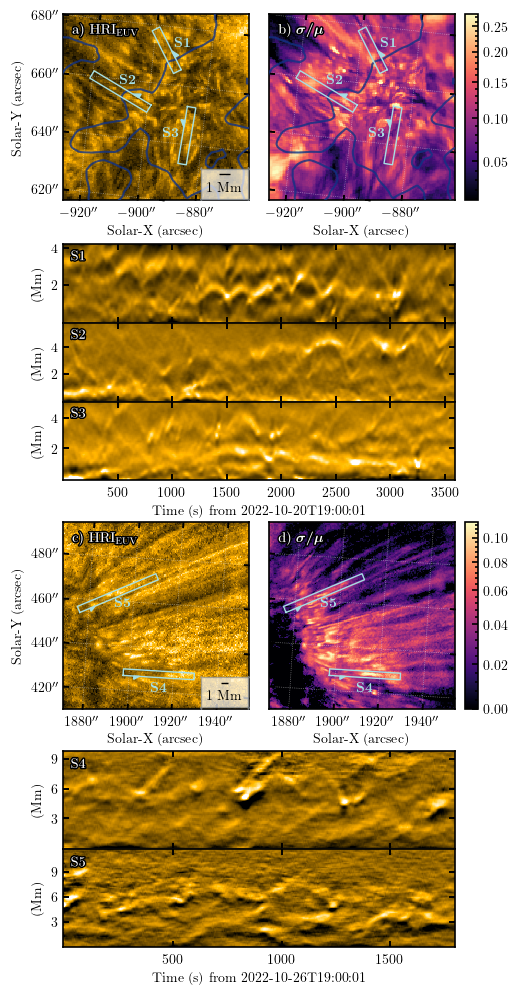

In [14]:
hri_1020_slit_1_pix_x, hri_1020_slit_1_pix_y = [80,65], [90,120]
hri_1020_slit_1_pixels_idx, hri_1020_slit_1_pixels_idy, hri_1020_slit_1_cube = \
    generate_slit_data(hri_1020_slit_1_pix_x, hri_1020_slit_1_pix_y, 7, hri_1020_map_seq,
                       map_wcs=hri_1020_map_wow.wcs)

hri_1020_slit_2_pix_x, hri_1020_slit_2_pix_y = [60,20], [64,88]
hri_1020_slit_2_pixels_idx, hri_1020_slit_2_pixels_idy, hri_1020_slit_2_cube = \
    generate_slit_data(hri_1020_slit_2_pix_x, hri_1020_slit_2_pix_y, 7, hri_1020_map_seq,
                       map_wcs=hri_1020_map_wow.wcs)

hri_1020_slit_3_pix_x, hri_1020_slit_3_pix_y = [90,83.3], [65,25]
hri_1020_slit_3_pixels_idx, hri_1020_slit_3_pixels_idy, hri_1020_slit_3_cube = \
    generate_slit_data(hri_1020_slit_3_pix_x, hri_1020_slit_3_pix_y, 7, hri_1020_map_seq,
                          map_wcs=hri_1020_map_wow.wcs)

hri_1026_slit_4_pix_x, hri_1026_slit_4_pix_y = [55,120], [33,29]
hri_1026_slit_4_pixels_idx, hri_1026_slit_4_pixels_idy, hri_1026_slit_4_cube = \
    generate_slit_data(hri_1026_slit_4_pix_x, hri_1026_slit_4_pix_y, 7, hri_1026_map_seq,
                          map_wcs=hri_1026_map_wow.wcs)

hri_1026_slit_5_pix_x, hri_1026_slit_5_pix_y = [14,86], [90.5,120.5]
hri_1026_slit_5_pixels_idx, hri_1026_slit_5_pixels_idy, hri_1026_slit_5_cube = \
    generate_slit_data(hri_1026_slit_5_pix_x, hri_1026_slit_5_pix_y, 7, hri_1026_map_seq,
                            map_wcs=hri_1026_map_wow.wcs)


with rc_context(ms_style_dict):
    fig = plt.figure(figsize=(5, 9.8), layout='constrained')
    gs = fig.add_gridspec(9, 2, height_ratios = [1]*2 + [0.8]*3 + [1]*4)
    ax1 = fig.add_subplot(gs[:2, 0], projection=hri_1020_map_wow)
    ax2 = fig.add_subplot(gs[:2, 1], projection=hri_1020_map_wow)

    hri_1020_map_wow.plot(axes=ax1, cmap='sdoaia171', title=False,
                        norm=ImageNormalize())
    im2 = hri_1020_map_std.plot(axes=ax2, cmap='magma', title=False,
                            norm=ImageNormalize(vmin=np.nanpercentile(hri_1020_map_std.data, 1),
                                                vmax=np.nanpercentile(hri_1020_map_std.data, 99.9),
                                                stretch=AsinhStretch(0.5)))
    
    for ax_ in (ax1,ax2):
        bounds = ax_.axis()
        with propagate_with_solar_surface(rotation_model='rigid'):
            spice_NeVIII_vel_map_1020_zoomin.draw_contours(levels=[-20],colors=["#113285"],alpha=0.8,
                                                                        axes=ax_,linestyles='solid')
        ax_.axis(bounds)
    
    plot_colorbar(im2, ax2, bbox_to_anchor=(1.05, 0, 0.07, 1))


    plot_slit_position(hri_1020_slit_1_pixels_idx, hri_1020_slit_1_pixels_idy, ax1, ax2, triangle_length=5, triangle_anchor_index=10, triangle_ratio=0.6,
                    color="#A5DEE4", alpha=1, text=r'\textbf{S1}',text_offset=12)
    
    
    plot_slit_position(hri_1020_slit_2_pixels_idx, hri_1020_slit_2_pixels_idy, ax1, ax2, triangle_length=5, triangle_anchor_index=10, triangle_ratio=0.6,
                    color="#A5DEE4", alpha=1, text=r'\textbf{S2}',text_offset=10)
    
    plot_slit_position(hri_1020_slit_3_pixels_idx, hri_1020_slit_3_pixels_idy, ax1, ax2, triangle_length=5, triangle_anchor_index=10, triangle_ratio=0.6,
                    color="#A5DEE4", alpha=1, text=r'\textbf{S3}',text_offset=12)

    wcs_scalebar(ax1,length=1*u.Mm, color='black', label=r'1 Mm', corner='bottom right', borderpad=0.0, 
                    frame=True,bbox_props=dict(boxstyle='round,pad=-0.1',facecolor='white', edgecolor='#91989F', alpha=0.7),
                    dsun=hri_1020_map_wow.dsun)
    
    ax3 = fig.add_subplot(gs[2, :], projection=hri_1020_slit_1_cube.wcs)
    hri_1020_slit_1_cube.plot(axes=ax3, aspect='auto', cmap='sdoaia171',
                              norm=ImageNormalize(vmin=np.nanpercentile(hri_1020_slit_1_cube.data, 0.1),
                                                  vmax=np.nanpercentile(hri_1020_slit_1_cube.data, 99.9),
                                                  ))

    ax4 = fig.add_subplot(gs[3, :], projection=hri_1020_slit_2_cube.wcs)
    hri_1020_slit_2_cube.plot(axes=ax4, aspect='auto', cmap='sdoaia171',
                              norm=ImageNormalize(vmin=np.nanpercentile(hri_1020_slit_2_cube.data, 0.1),
                                                  vmax=np.nanpercentile(hri_1020_slit_2_cube.data, 99.9),
                                                  ))
    
    ax5 = fig.add_subplot(gs[4, :], projection=hri_1020_slit_3_cube.wcs)
    hri_1020_slit_3_cube.plot(axes=ax5, aspect='auto', cmap='sdoaia171',
                              norm=ImageNormalize(vmin=np.nanpercentile(hri_1020_slit_3_cube.data, 0.1),
                                                  vmax=np.nanpercentile(hri_1020_slit_3_cube.data, 99.5),
                                                  ))
    
    ax6 = fig.add_subplot(gs[5:7, 0], projection=hri_1026_map_wow)
    ax7 = fig.add_subplot(gs[5:7, 1], projection=hri_1026_map_wow)

    hri_1026_map_wow.plot(axes=ax6, cmap='sdoaia171', title=False,
                        norm=ImageNormalize())
    
    im7 = hri_1026_map_std.plot(axes=ax7, cmap='magma', title=False,
                            norm=ImageNormalize(vmin=np.nanpercentile(hri_1026_map_std.data, 0.1),
                                                vmax=np.nanpercentile(hri_1026_map_std.data, 99.9),
                                                stretch=AsinhStretch(0.5)))
    
    wcs_scalebar(ax6,length=1*u.Mm, color='black', label=r'1 Mm', corner='bottom right', borderpad=0.0, 
                frame=True,bbox_props=dict(boxstyle='round,pad=-0.1',facecolor='white', edgecolor='#91989F', alpha=0.7),
                dsun=hri_1026_map_wow.dsun)
    
    plot_colorbar(im7, ax7, bbox_to_anchor=(1.05, 0, 0.07, 1))

    plot_slit_position(hri_1026_slit_4_pixels_idx, hri_1026_slit_4_pixels_idy, ax6, ax7, triangle_length=5, triangle_anchor_index=10, triangle_ratio=0.6,
                    color="#A5DEE4", alpha=1, text=r'\textbf{S4}',text_offset=12)
    
    plot_slit_position(hri_1026_slit_5_pixels_idx, hri_1026_slit_5_pixels_idy, ax6, ax7, triangle_length=5, triangle_anchor_index=10, triangle_ratio=0.6,
                    color="#A5DEE4", alpha=1, text=r'\textbf{S5}',text_offset=10)
    

    ax8 = fig.add_subplot(gs[7,:], projection=hri_1026_slit_4_cube.wcs)
    hri_1026_slit_4_cube.plot(axes=ax8, aspect='auto', cmap='sdoaia171',
                              norm=ImageNormalize(vmin=np.nanpercentile(hri_1026_slit_4_cube.data, 1),
                                                    vmax=np.nanpercentile(hri_1026_slit_4_cube.data, 99.9),
                                                  stretch=AsinhStretch(0.5)))
    
    ax9 = fig.add_subplot(gs[8,:], projection=hri_1026_slit_5_cube.wcs)
    hri_1026_slit_5_cube.plot(axes=ax9, aspect='auto', cmap='sdoaia171',
                              norm=ImageNormalize(vmin=np.nanpercentile(hri_1026_slit_5_cube.data, 1),
                                                    vmax=np.nanpercentile(hri_1026_slit_5_cube.data, 99.9),
                                                  stretch=AsinhStretch(0.5)))


    ax1.set_xlabel('Solar-X (arcsec)', labelpad=0.8)
    ax1.set_ylabel('Solar-Y (arcsec)',)

    ax2.coords[1].axislabels.set_visible(False)
    ax2.coords[1].set_ticklabel_visible(False)
    ax2.set_xlabel('Solar-X (arcsec)', labelpad=0.8)

    ax6.set_xlabel('Solar-X (arcsec)', labelpad=0.8)
    ax6.set_ylabel('Solar-Y (arcsec)',)

    ax7.coords[1].axislabels.set_visible(False)
    ax7.coords[1].set_ticklabel_visible(False)
    ax7.set_xlabel('Solar-X (arcsec)', labelpad=0.8)

    ax1.text(0.05, 0.95, r'\textbf{a) HRI\textsubscript{EUV}}', transform=ax1.transAxes, color='white', fontsize=10, 
             ha='left', va='top', path_effects=[path_effects.withStroke(linewidth=2, foreground='black')])
    
    ax2.text(0.05, 0.95, r'\textbf{b)} $\boldsymbol{\sigma/\mu}$', transform=ax2.transAxes, color='white', fontsize=10,
                ha='left', va='top', path_effects=[path_effects.withStroke(linewidth=2, foreground='black')])
    
    ax3.text(0.02, 0.92, r'\textbf{S1}', transform=ax3.transAxes, color='white', fontsize=10,
                ha='left', va='top', path_effects=[path_effects.withStroke(linewidth=2, foreground='black')])
    
    ax4.text(0.02, 0.92, r'\textbf{S2}', transform=ax4.transAxes, color='white', fontsize=10,
                ha='left', va='top', path_effects=[path_effects.withStroke(linewidth=2, foreground='black')])
    
    ax5.text(0.02, 0.92, r'\textbf{S3}', transform=ax5.transAxes, color='white', fontsize=10,
                ha='left', va='top', path_effects=[path_effects.withStroke(linewidth=2, foreground='black')])

    for ax_ in (ax3,ax4,ax5):
        ax_.coords[0].set_ticklabel_visible(False)
        ax_.coords[0].axislabels.set_visible(False)
        ax_.coords[1].set_ticks(spacing=2*u.Mm)
        ax_.set_ylabel('(Mm)')
    
    ax5.coords[0].set_ticklabel_visible(True)
    ax5.coords[0].axislabels.set_visible(True)
    ax5.set_xlabel(f'Time (s) from {hri_1020_map_seq[0].date.isot[:-4]}',labelpad=0.8)

    ax6.text(0.05, 0.95, r'\textbf{c) HRI\textsubscript{EUV}}', transform=ax6.transAxes, color='white', fontsize=10,
                ha='left', va='top', path_effects=[path_effects.withStroke(linewidth=2, foreground='black')])   
    
    ax7.text(0.05, 0.95, r'\textbf{d)} $\boldsymbol{\sigma/\mu}$', transform=ax7.transAxes, color='white', fontsize=10,
                ha='left', va='top', path_effects=[path_effects.withStroke(linewidth=2, foreground='black')])   
    
    ax8.text(0.02, 0.92, r'\textbf{S4}', transform=ax8.transAxes, color='white', fontsize=10,
                ha='left', va='top', path_effects=[path_effects.withStroke(linewidth=2, foreground='black')])
    
    ax9.text(0.02, 0.92, r'\textbf{S5}', transform=ax9.transAxes, color='white', fontsize=10,
                ha='left', va='top', path_effects=[path_effects.withStroke(linewidth=2, foreground='black')])

    ax8.coords[0].set_ticklabel_visible(False)
    ax8.coords[0].axislabels.set_visible(False)
    ax8.coords[1].set_ticks(spacing=3*u.Mm)
    ax8.set_ylabel('(Mm)')

    ax9.set_xlabel(f'Time (s) from {hri_1026_map_seq[0].date.isot[:-4]}',labelpad=0.8)
    ax9.set_ylabel('(Mm)')
    ax9.coords[1].set_ticks(spacing=3*u.Mm)

    fig.get_layout_engine().set(w_pad=1/72., h_pad=0., hspace=0,
                            wspace=0)
    

    plt.savefig("../../figs/ms_eis_eui_upflow/eui_upflow_stackplot.pdf", bbox_inches='tight', dpi=300)
    plt.show()
